# "PyMC3 with labeled coords and dims"
> "Go crazy with your virtual label-maker!"

- toc: true 
- author: Oriol Abril
- badges: true
- categories: [python, arviz, pymc3, xarray]
- tags: [data storage, arviz converters]
- image: images/nb/labeled_arys.png
- twitter_large_image: true
- read_time: false

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

rng = np.random.default_rng()

In [2]:
#hide
# use text display to keep blog fast and responsive, 
# do not execute this cell when running the code
import xarray as xr
xr.set_options(display_style="text");

In [3]:
az.style.use("arviz-darkgrid")

## For the :heart: of labeled arrays
For all of us who love labeled arrays, [PyMC 3.9.0](https://github.com/pymc-devs/pymc3/blob/master/RELEASE-NOTES.md#pymc3-390-16-june-2020) came with some amazing news: support for using coordinate and dimension names to specify the shapes of variables in a `pm.Model`. While this is good news by its own merit, its seamless integration with ArviZ even more impactful and relevant.

This post will focus on using PyMC3 coords and dims and the conversion of traces and models to [`InferenceData`](https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html) using `arviz.from_pymc3`. To see `InferenceData` in action, refer to [this example](https://docs.pymc.io/notebooks/multilevel_modeling.html) in PyMC docs.

We will use an example based approach and use models from the [example gallery](https://docs.pymc.io/nb_examples/index.html) to illustrate how to use coords and dims within PyMC3 models.

## 1st example: rugby analytics
We will use an alternative parametrization of the same model used in the [rugby analytics example](https://docs.pymc.io/notebooks/rugby_analytics.html) taking advantage of dims and coords. Here, we will use as observations a 2d matrix, whose rows are the matches and whose columns are the field: home and away.

The first step after preprocessing is to define the dimensions used by the model and their coordinates. In our case, we have 3 dimensions:

* `team`: each team will have its own offensive and defensive power
* `match`: an integer identifying the match. There are 6 teams who play twice against each other so we have `6*5*2=60` matches
* `field`: either home or away.

These coordinates are passed to `pm.Model` as a dict whose keys are dimension names and whose values are coordinate values. The dimensions can then be used when defining PyMC3 variables to indicate their shape.

In [4]:
df_rugby = pd.read_csv(pm.get_data('rugby.csv'), index_col=0)
home_idx, teams = pd.factorize(df_rugby["home_team"], sort=True)
away_idx, _ = pd.factorize(df_rugby["away_team"], sort=True)

In [5]:
coords = {
    "team": teams,
    "match": np.arange(60),
    "field": ["home", "away"],
}
with pm.Model(coords=coords) as rugby_model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star), dims="team")
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star), dims="team")
    home_theta = tt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = tt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    points = pm.Poisson(
        'home_points', 
        mu=tt.stack((home_theta, away_theta)).T, 
        observed=df_rugby[["home_score", "away_score"]],
        dims=("match", "field")
    )
    rugby_trace = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


We have now defined the shapes or our variables, which is convenient and helps understanding the code, but the dimensions and coordinates are lost during sampling. `pm.MultiTrace` objects do not store the labeled coordinates of their variables. 

In [6]:
print(rugby_trace)
print(rugby_trace["atts"])

<MultiTrace: 4 chains, 1000 iterations, 10 variables>
[[ 0.24332494 -0.07735264  0.13243179 -0.38098319 -0.13746178  0.22004088]
 [ 0.22410532 -0.0226893   0.14800871 -0.28465151 -0.21456246  0.14978924]
 [ 0.2929947  -0.10987094  0.06507589 -0.33557635 -0.07596186  0.16333854]
 ...
 [ 0.25308745 -0.09960903  0.09939358 -0.3320184  -0.07522287  0.15436927]
 [ 0.2842837  -0.15610569  0.12018721 -0.42780215 -0.03274738  0.21218431]
 [ 0.24447545 -0.12604242  0.12721251 -0.35437556 -0.08918233  0.19791235]]


To also take advantage of the labeled coords and dims for exploratory analysis of the results, we have to convert the results to [`az.InferenceData`](https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html). This can be done with `az.from_pymc3` or using the `return_inferencedata=True` argument in `pm.sample`. To avoid having to resample again, we will use the former and use the latter in the second example.

ArviZ is aware of the model context, and will use it to get the coords and dims automatically. If necessary however, we may also modify or add dimensions or coordinates using the `dims`/`coords` arguments of `from_pymc3`. We'll also see an example of this afterwards.

In [7]:
rugby_idata = az.from_pymc3(rugby_trace, model=rugby_model)
rugby_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## 2nd example: radon multilevel model
We will now use one of the many models in the [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/notebooks/multilevel_modeling.html) notebook to dive deeper into coords and dims functionality. We won't cover the model itself, it's already explained in the example notebook, we will explain in detail how are labeled coords and dims being used.

The code used to load and clean the data is hidden, click the button below to see it.

In [8]:
#collapse-hide
srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)
srrs_mn.county = srrs_mn.county.map(str.strip)
srrs_mn["county_code"], mn_counties = pd.factorize(srrs_mn.county)
srrs_mn["log_radon"] = np.log(srrs_mn.activity + 0.1)

The first step is again defining the dimensions and their coordinate values:

* `Level`: observations can correspond to the basement of the first floor
* `obs_id`: unique integer identifying each observation
* `County`: each county has its own basement, intercept: `a`, and first floor, slope `b`, effects. Details are in the example notebook
* `param`: one of `a`, `b`
* `param_bis`: same as param, used for the covariance matrix because a variable can't have repeated dimensions

In [9]:
coords = {
    "Level": ["Basement", "Floor"], 
    "obs_id": np.arange(n),
    "County": mn_counties,
    "param": ["a", "b"],
    "param_bis": ["a", "b"],
}

We'll begin to define the model creating the indexing arrays that will implement the hierarchical model. We are using the `pm.Data` container to tell ArviZ to store the variables in the `constant_data` group. Moreover, `pm.Data` defines a theano shared variable, so its values can be modified in order to call `pm.sample_posterior_predictive` using different data. This is particularly interesting for regressions for example in order to generate predictions for the model.

In [10]:
with pm.Model(coords=coords) as radon_model:
    floor_idx = pm.Data("floor_idx", srrs_mn.floor, dims="obs_id")
    county_idx = pm.Data("county_idx", srrs_mn.county_code, dims="obs_id")

We'll also use a `LKJCholeskyCov`as prior for the covariance matrix. As you can see, it has no `dims` argument. Given that we are going to use `return_inferencedata=True` here in order to get an InferenceData directly as a result of `pm.sample`, we will have to indicate the dims that correspond to these variables as `idata_kwargs`. `idata_kwargs` is used to indicate `pm.sample` what arguments to pass to [az.from_pymc3](https://arviz-devs.github.io/arviz/generated/arviz.from_pymc3.html#arviz.from_pymc3), which is called internally to convert the trace to InferenceData.

In [11]:
with radon_model:
    sd_dist = pm.Exponential.dist(0.5)
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    z = pm.Normal("z", 0.0, 1.0, dims=("param", "County"))
    
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True
    )

We now will store two intermediate results as variables. However, one is wrapped inside a `pm.Deterministic` whereas the other is not. Both are equally valid. `pm.Deterministic` tells PyMC3 to store that variable in the trace. Thus `pm.Deterministic` should only be used when we actively want to store the intermediate result. In our case, we want to store `ab_county` but not `theta`.

In [12]:
with radon_model:
    ab_county = pm.Deterministic("ab_county", tt.dot(chol, z).T, dims=("County", "param"))
    theta = a + ab_county[county_idx, 0] + (b + ab_county[county_idx, 1]) * floor_idx

    sigma = pm.Exponential("sigma", 1.0)
    y = pm.Normal("y", theta, sigma=sigma, observed=srrs_mn.log_radon, dims="obs_id")

Finally we will call `pm.sample` with `return_inferencedata=True` and defining the dimensions of the covariance matrix as `idata_kwargs`.

In [13]:
with radon_model:
    radon_idata = pm.sample(
        2000, tune=2000, target_accept=0.99, random_seed=75625, return_inferencedata=True,
        idata_kwargs={"dims": {"chol_stds": ["param"], "chol_corr": ["param", "param_bis"]}}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, chol, z, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 204 seconds.
The number of effective samples is smaller than 25% for some parameters.


## There is life outside the posterior
The posterior is the center of Bayesian analysis but other quantities such as the prior or the posterior predictive are also crucial to an analysis workflow. We'll use a linear regression to quickly showcase some of the key steps in a Bayesian workflow: prior predictive checks, posterior sampling, posterior predictive checks (using LOO-PIT) and out of sample predictions.

We will start generating some simulated data (code hidden, click to expand) and defining the model. As it's a simple linear regression we'll only have scalar parameters, `a`, `b` and `sigma`.

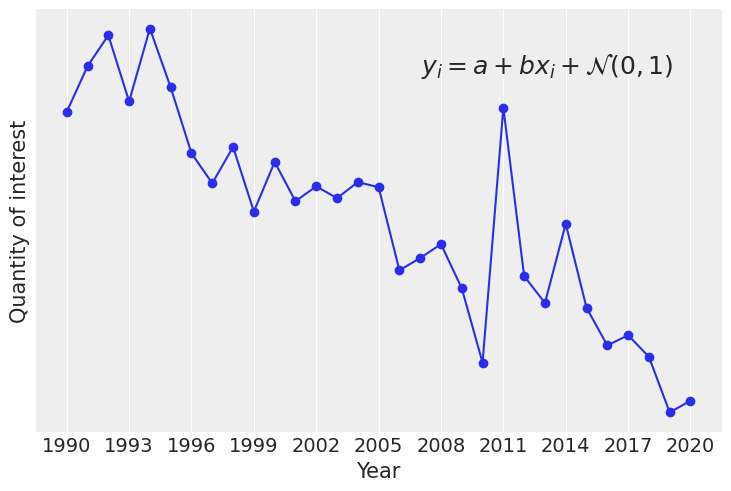

In [14]:
#collapse-hide
a_ = 2
b_ = -0.4
x_ = np.linspace(0, 10, 31)
year_ = np.arange(2021-len(x_), 2021)
y_ = a_ + b_ * x_ + rng.normal(size=len(x_))

fig, ax = plt.subplots()
ax.plot(x_, y_, "o-")
ax.text(
    0.93, 0.9, r"$y_i = a + bx_i + \mathcal{N}(0,1)$", ha='right', va='top', transform=ax.transAxes, fontsize=18
)

ax.set_xticks(x_[::3])
ax.set_xticklabels(year_[::3])
ax.set_yticks([])
ax.set_xlabel("Year")
ax.set_ylabel("Quantity of interest");

In [15]:
coords = {"year": year_}
with pm.Model(coords=coords) as linreg_model:
    x = pm.Data("x", x_, dims="year")
    
    a = pm.Normal("a", 0, 3)
    b = pm.Normal("b", 0, 2)
    sigma = pm.HalfNormal("sigma", 2)
    
    y = pm.Normal("y", a + b * x, observed=y_, dims="year")

We have now written a model in order to study our super interesting quantity `y`. We have used everything we have seen so far, the `pm.Data` container and the labeled dims and coords. We will now simulate a workflow starting from prior predictive checks and finishing with predicting the values of our _quantity of interest_ in 2021 and 2022. 

### Priors
We start by sampling both prior and prior predictive with `pm.sample_prior_predictive`. This will generate a dictionary whose keys are variable names and whose values are numpy arrays. We can then pass this dictionary to `az.from_pymc3` as the `prior` argument. ArviZ will then use the information in the `pm.Model` instance to 1) split the variables between `prior` and `prior_predictive` groups, 2) fill the `observed_data` and `constant_data` groups and 3) get the `dims` and `coords` if present.

In [16]:
with linreg_model:
    prior = pm.sample_prior_predictive(700)
    linreg_idata = az.from_pymc3(prior=prior)
linreg_idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

We can now use `plot_ppc` to perform prior predictive checks for our model.

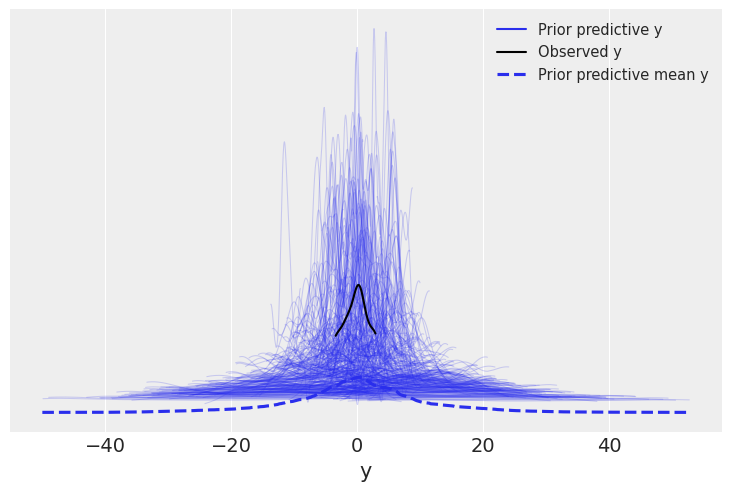

In [17]:
az.plot_ppc(linreg_idata, group="prior");

### Posterior
The next step will be computing the posterior. As we have seen, we can use `return_inferencedata` to get an `InferenceData` as a result of `pm.sample`. In this case however, we will store it as an auxiliary variable to then use `InferenceData.extend` and add the new groups to the `linreg_idata`. 

In [18]:
with linreg_model:
    idata_aux = pm.sample(return_inferencedata=True)
linreg_idata.extend(idata_aux)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [19]:
linreg_idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats
	> constant_data

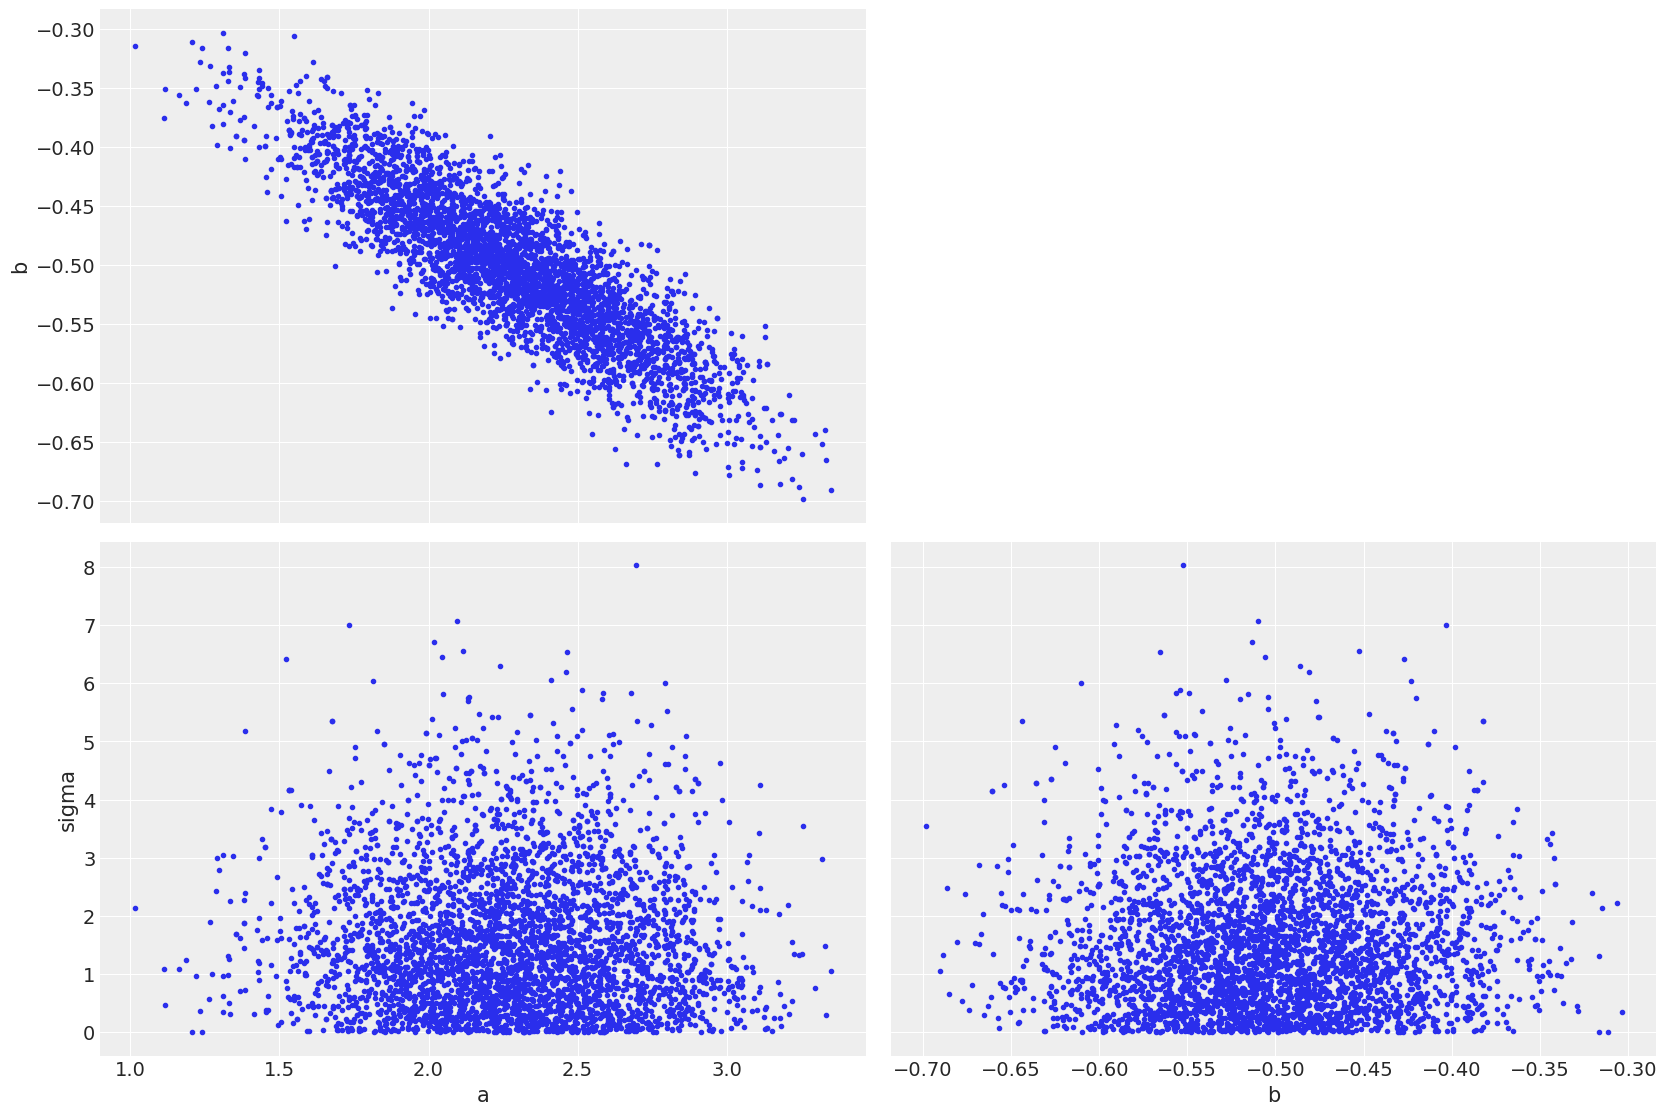

In [20]:
az.plot_pair(linreg_idata);

### Posterior predictive
Our third step will be to evaluate the posterior predictive at the observations so we can perform model checking with functions such as `plot_ppc` or `plot_loo_pit`. Here again we are using the `extend` trick to keep all our data as part of the same `InferenceData`. This has two main advantages. `plot_loo_pit` requires both the `posterior_predictive` group, generated here and the `log_likelihood` group which was created in `pm.sample`. In addition, keeping all our data in a single `InferenceData` means we can store it as a netCDF and share a single file to allow reproducing the whole exploratory analysis of our model.

In [21]:
with linreg_model:
    post_pred = pm.sample_posterior_predictive(linreg_idata)
    idata_aux = az.from_pymc3(posterior_predictive=post_pred)
linreg_idata.extend(idata_aux)

In [22]:
linreg_idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats
	> constant_data
	> posterior_predictive

We will now get to use `plot_loo_pit`, which as expected does not show any issues. To learn how to interpret those plots, you can read the [LOO-PIT tutorial](https://oriolabril.github.io/oriol_unraveled/python/arviz/pymc3/2019/07/31/loo-pit-tutorial.html).

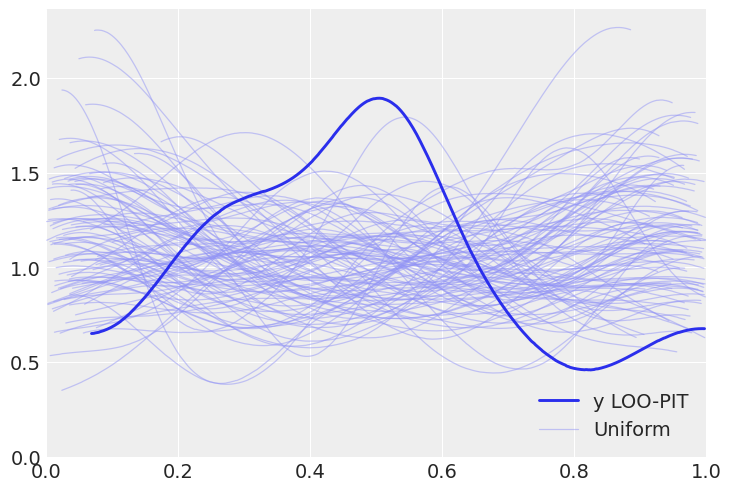

In [23]:
az.plot_loo_pit(linreg_idata, y="y");

### Predictions
Finally, our last step will be to get some predictions, which in this case is evaluating the posterior predictive at positions different than the observations. In the example below, we are evaluating our predictions at 2021 and 2020. To do so, we are using `pm.set_data` to modify the values of `x` to the ones that correspond to these two future years.

Here we will use `from_pymc3_predictions` instead of `from_pymc3`+`extend`. `from_pymc3_predictions` combines functionality from both of these functions and let's the user choose how to handle predictions depending on the goal at hand: if `idata_orig` is not present, the returned object will be an `InferenceData` containing only the predictions groups; if `idata_orig` is present and `inplace=False` the returned `InferenceData` will be a copy of `idata_orig` with the predictions groups added, and with `inplace=True` there is no returned object, the preditcions groups are added to `idata_orig` which is not returned.

In [24]:
with linreg_model:
    pm.set_data({"x": x_[-1] + x_[1:3]})
    predictions = pm.sample_posterior_predictive(linreg_idata)
    az.from_pymc3_predictions(
        predictions, coords={"year": [2021, 2022]}, idata_orig=linreg_idata, inplace=True
    )

In [25]:
linreg_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> predictions_constant_data

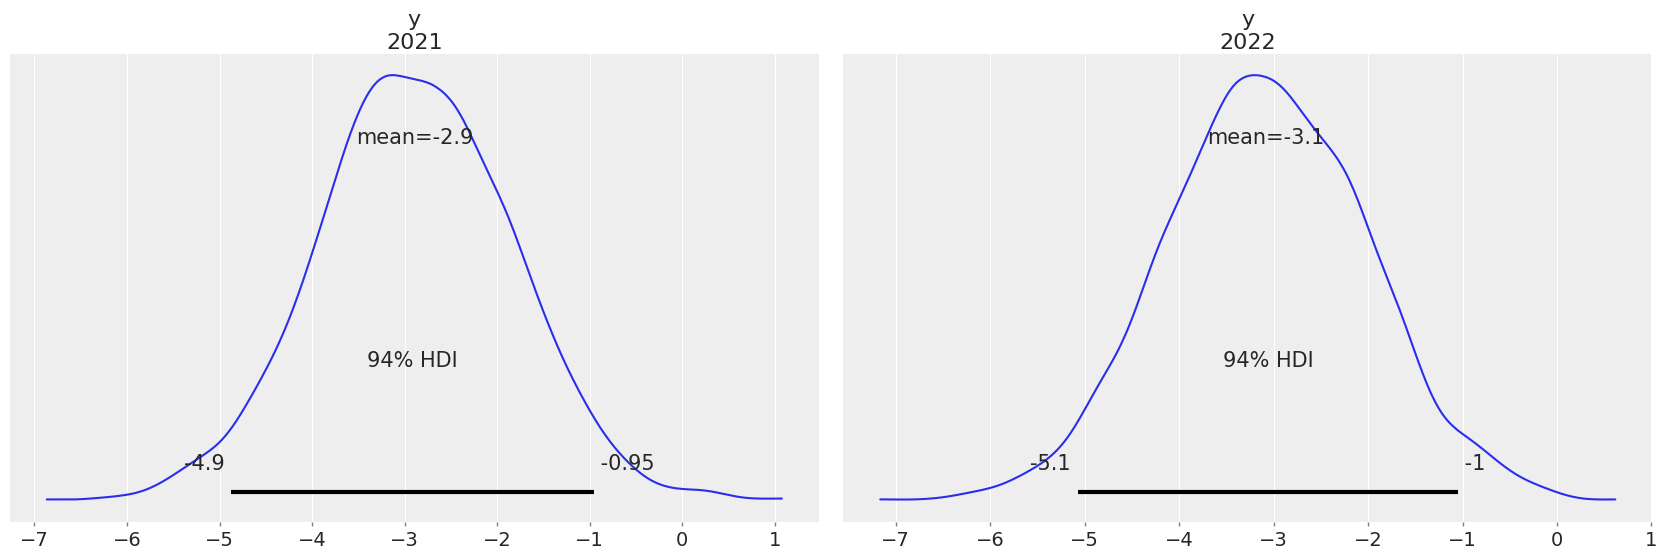

In [26]:
az.plot_posterior(linreg_idata, group="predictions");

## Extra: generating the post image
Here is the code used to generate the summary image for this post. Take a look if you want to use matplotlib to create array diagrams!

In [27]:
#hide
import matplotlib
plt.rcParams.update(matplotlib.rcParamsDefault)

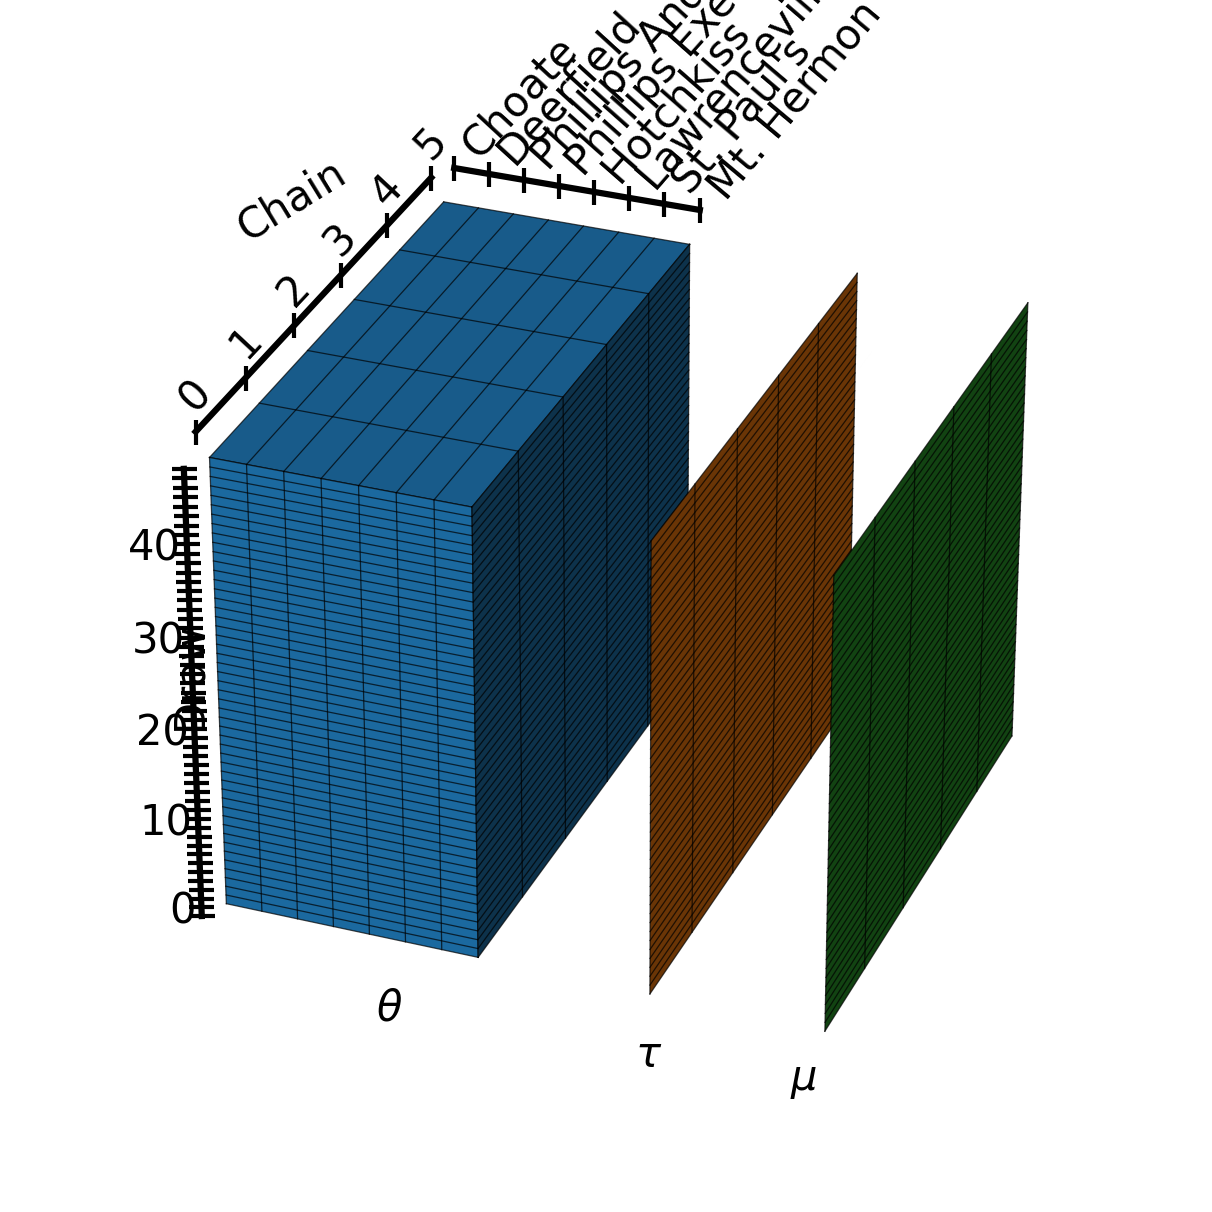

In [28]:
#collapse-hide
from mpl_toolkits.mplot3d import Axes3D

points = np.array([
    [-1, -1, -1],
    [1, -1, -1 ],
    [1, 1, -1],
    [-1, 1, -1],
    [-1, -1, 1],
    [1, -1, 1 ],
    [1, 1, 1],
    [-1, 1, 1]
])

fig = plt.figure(dpi=300)
ax = fig.add_axes([0, .05, 1, .8], projection='3d')
side = 3 
r = side * np.array([-1,1])
one_2d = side * np.ones((1,1))
one_1d = side * np.ones(1)
X, Y = np.meshgrid(r, r)

################
###  theta   ###
################
ax.plot_surface(X,Y,one_2d, color="C0", zorder=1)
ax.plot_surface(X,-one_2d,Y, color="C0", zorder=1)
ax.plot_surface(one_2d,X,Y, color="C0", zorder=1)
ax.text2D(0.3, 0.14, r"$\theta$", transform=ax.transAxes)

# school dim
school_grid = np.linspace(-1, 1, 8) * side
school_one = np.ones_like(school_grid) * side * 1.1
schools = np.array(["Choate", "Deerfield", "Phillips Andover", "Phillips Exeter", 
                    "Hotchkiss", "Lawrenceville", "St. Paul's", "Mt. Hermon"])
ax.plot(school_grid, school_one, school_one, marker="|", color="k")
for school, pos in zip(schools, school_grid):
    ax.text(pos, side*1.1, side*1.15, f"{school}", zdir="y", clip_on=False)
    
# chain dim
chain_grid = np.linspace(-1, 1, 6) * side
chain_one = np.ones_like(chain_grid) * side * 1.1
ax.plot(-chain_one, chain_grid, chain_one, marker="|", color="k")
for chain, pos in enumerate(chain_grid):
    ax.text(-side*1.1, pos, side*1.15, f"{chain}", zdir="y", va="bottom", ha="center")
ax.text(-side*1.3, 0, side*1.3, "Chain", zdir=(1, 1, .2), va="bottom", ha="center")
    
# draw dim
draw_grid = np.linspace(-1, 1, 50) * side
draw_one = np.ones_like(draw_grid) * side * 1.1
draws = np.arange(0, 50, 10)
ax.plot(-draw_one, -draw_one, draw_grid, marker="_", color="k")
for draw, pos in zip(draws, draw_grid[draws]):
    ax.text(-side*1.1, -side*1.15, pos, f"{draw}", zdir=None, ha="right")
ax.text2D(0.12, 0.4, "Draw", transform=ax.transAxes, rotation="vertical")

################
###   tau    ###
################
ax.plot_surface(4+one_2d,X,Y, color="C1", zorder=1)
ax.text2D(0.525, 0.1, r"$\tau$", transform=ax.transAxes)


################
###    mu    ###
################
ax.plot_surface(8+one_2d,X,Y, color="C2", zorder=1)
ax.text2D(0.66, 0.08, r"$\mu$", transform=ax.transAxes)


################
###  grids   ###
################
grid = np.linspace(-1, 1, 10) * side
grid_one = np.ones(10)
lw = .3; alpha = .7
for chain_pos in chain_grid:
    ax.plot(grid, grid_one * chain_pos, grid_one * side, color="k", alpha=alpha, zorder=3, lw=lw)
    ax.plot(grid_one * side, grid_one * chain_pos, grid, color="k", alpha=alpha, zorder=5, lw=lw)
    ax.plot(grid_one * side + 4, grid_one * chain_pos, grid, color="k", alpha=alpha, zorder=6, lw=lw)
    ax.plot(grid_one * side + 8, grid_one * chain_pos, grid, color="k", alpha=alpha, zorder=7, lw=lw)
for draw_pos in draw_grid:
    ax.plot(grid, -grid_one * side, grid_one * draw_pos,  color="k", alpha=alpha, zorder=4, lw=lw)
    ax.plot(grid_one * side, grid, grid_one * draw_pos,  color="k", alpha=alpha, zorder=5, lw=lw)
    ax.plot(grid_one * side + 4, grid, grid_one * draw_pos,  color="k", alpha=alpha, zorder=6, lw=lw)
    ax.plot(grid_one * side + 8, grid, grid_one * draw_pos,  color="k", alpha=alpha, zorder=7, lw=lw)
for school_pos in school_grid:
    ax.plot(grid_one * school_pos, grid, grid_one * side,  color="k", alpha=alpha, zorder=4, lw=lw)
    ax.plot(grid_one * school_pos, -grid_one * side, grid, color="k", alpha=alpha, zorder=4, lw=lw)

ax.axis("off");
ax.view_init(azim=-69)
#fig.savefig("labeled_arys.png", dpi=300)

Package versions used to generate this post:

In [29]:
#hide_input
%load_ext watermark
%watermark -n -u -v -iv -w

numpy      1.19.1
arviz      0.9.0
xarray     0.16.1
matplotlib 3.3.1
pandas     1.1.1
pymc3      3.9.3
last updated: Tue Sep 22 2020 

CPython 3.6.9
IPython 7.16.1
watermark 2.0.2


---
Comments are not enabled for this post, to inquiry further about the contents of the post, ask on [PyMC Discourse](https://discourse.pymc.io/). Feel free to tag me at [@OriolAbril](https://discourse.pymc.io/u/oriolabril)